In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import sys
module_path = os.path.join(os.environ['HOME'],'a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# wrapper around reader functions to return a single combined dataframe
from mmctools.dataloaders import read_files

In [5]:
# more sophisticated data readers for when default pd.read_csv() doesn't cut it
from mmctools.measurements import metmast as mm

In [6]:
from mmctools.helper_functions import covariance

In [7]:
from mmctools.plotting import plot_timehistory_at_height

# Process met mast data from WFIP2/PS12
written by [Eliot Quon](mailto:eliot.quon@nrel.gov)
- Combine data from wfip2/met.z[28-31].b0 on Aug 21, 2016
- Data were originally processed and cleaned by Tonya Martin (PNNL)
- Met mast is located at 45.638004,-120.642973 and has 4 sonics on south- and west-facing booms at two heights:
    - z28: south, 80m
    - z29: west, 80m
    - z30: south, 50m
    - z31: west, 50m
- Measurement constraints (from the [DAP](https://a2e.energy.gov/data/wfip2/met.z28.b0)):
> During stable atmospheric conditions, turbulence intensity and atmospheric gradients often are small, approaching or exceeding the measurement resolution of sonic anemometers. Under these conditions, advection from beyond the normal fetch also can occur, making interpretation of the fluxes difficult. Notably, the Physics Site-12 tower sonic anemometer measurements can be affected when the wind blows through the tower structure. Some unusual biases in the vertical velocities measured at the Physics Site-12 tower with west wind conditions also have not been adequately explained.

In [8]:
# dataset name format: project/class.instance.level
dataset_series = 'met.z{:02d}.b0'
sonics = range(28,32)
startdate = pd.to_datetime('2016-08-21')
enddate = pd.to_datetime('2016-08-22')

# optional dataset file specs
dataext = 'txt' # file type, dictated by extension
dataext1 = None  # 'winds' # e.g., *.winds.txt

download_path = 'data'
overwrite_files = False # force download even if files already exist

In [9]:
sonic_heights = {
    28: 80.,
    29: 80.,
    30: 50.,
    31: 50.,
}
sonic_dirs = {
    28: 's',
    29: 'w',
    30: 's',
    31: 'w',
}

## Download data from the DAP
This depends on the `a2e` module provided by the `dap-py` package (https://github.com/a2edap/dap-py). Current, the module is in beta, located within a private repo--contact [Matt Macduff](mailto:Matt.Macduff@pnnl.gov) for more information. 

In [10]:
import A2e
a2e = A2e.A2e()
a2e.setup_cert_auth()

No authentication found. Using guest credentials...
username: quon
password: ········
Success!


True

In [11]:
filelist = {}
for sonicid in sonics:
    dataset = 'wfip2/'+dataset_series.format(sonicid)
    filter_arg = {
        'Dataset': dataset,
        'date_time': {
            'between': [startdate.strftime('%Y%m%d%H%M%S'), enddate.strftime('%Y%m%d%H%M%S')]
        }
    }
    if dataext:
        filter_arg['file_type'] = dataext
    if dataext1:
        filter_arg['ext1'] = dataext1
    datafiles = a2e.search(filter_arg)
    print(len(datafiles),'data files selected from',dataset)
    filelist[sonicid] = a2e.download_files(datafiles, path=download_path, force=overwrite_files)

25 data files selected from wfip2/met.z28.b0
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.000000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.040000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.030000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.010000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.020000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.050000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.060000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.070000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.080000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.100000.sonic80ms.txt
Download successful! data/wfip2.met.z28.b0/met.z28.b0.20160821.110000.sonic80ms.txt
Download successful! data/wfip2

Download successful! data/wfip2.met.z31.b0/met.z31.b0.20160821.180000.sonic50mw.txt
Download successful! data/wfip2.met.z31.b0/met.z31.b0.20160821.060000.sonic50mw.txt
Download successful! data/wfip2.met.z31.b0/met.z31.b0.20160822.000000.sonic50mw.txt
Download successful! data/wfip2.met.z31.b0/met.z31.b0.20160821.120000.sonic50mw.txt


## Process the downloaded files
These files are a bit tricky because only time is contained in the data, and the date should be parsed from the filename. Resampling is also not straightforward because the number of rows (i.e., datapoints) varies for some reason. 

There are two approaches to reading the data and resampling to 1-Hz:
- Quick and dirty: read every 20th row (for data at 20 Hz). 
- More reliable: a computationally slower (but more reliable) alternative is to reindex and take the first occurrence of each HH:MM:SS entry.

### approach 1: quick and dirty

### approach 2: more reliable

In [12]:
%%time
dflist = []
for sonicid in sonics:
    dapname = dataset_series.format(sonicid)
    sonic_height = sonic_heights[sonicid]
    sonic_dir = sonic_dirs[sonicid]
    print(dapname,' height:',sonic_height,' boom dir:',sonic_dir)
    # sample filename: "met.z28.b0.20160822.000000.sonic80ms.txt"
    fname_datetime_format = dapname + '.%Y%m%d.%H%M%S.sonic{:02d}m{:s}.txt'.format(int(sonic_height),sonic_dir)
    df = read_files(filelist[sonicid],
                    reader=mm.read_data, column_spec=mm.Metek_USA1,
                    height=sonic_height,
                    # for parsing datetime information from filename
                    datetime_start=lambda fname: fname,
                    datetime_start_format=fname_datetime_format,
                    # sampling information
                    data_freq='50ms', # offset string for data sampled at 20Hz
                    # additional arguments for pd.read_csv()
                    delim_whitespace=True, # instead of comma-separated values
                   )
    df = df.reset_index(1) # revert from multi-index back to datetime index
    df = df.resample('1s').first() # resample at 1Hz
    df = df.set_index('height',append=True) # add second index level
    df['sonicdir'] = sonic_dir
    dflist.append(df)
# CPU times: user 1min 1s, sys: 4.46 s, total: 1min 6s
# Wall time: 1min 5s

met.z28.b0  height: 80.0  boom dir: s


/Users/equon/a2e-mmc/mmctools/measurements/metmast.py:188: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  periods=len(df), freq=data_freq)


met.z29.b0  height: 80.0  boom dir: w
met.z30.b0  height: 50.0  boom dir: s
met.z31.b0  height: 50.0  boom dir: w
CPU times: user 1min 1s, sys: 5.01 s, total: 1min 6s
Wall time: 1min 11s


### combine all the data

In [13]:
df = pd.concat(dflist)

In [14]:
# specifying `datetime_start` created a new 'datetime' column, so drop the old 'time' column 
df = df.drop(columns='time')

In [15]:
df.head()

,,w,Ts,wspd,wdir,sonicdir
datetime,height,,,,,
2016-08-21 00:00:00,80.0,0.18,303.82,3.352149,87.948491,s
2016-08-21 00:00:01,80.0,0.04,303.88,3.228157,100.892231,s
2016-08-21 00:00:02,80.0,0.17,303.86,3.485742,93.289243,s
2016-08-21 00:00:03,80.0,0.08,303.79,3.012125,84.857235,s
2016-08-21 00:00:04,80.0,-0.17,303.79,3.504882,75.289720,s


In [16]:
times = df.index.levels[0]
times

DatetimeIndex(['2016-08-21 00:00:00', '2016-08-21 00:00:01',
               '2016-08-21 00:00:02', '2016-08-21 00:00:03',
               '2016-08-21 00:00:04', '2016-08-21 00:00:05',
               '2016-08-21 00:00:06', '2016-08-21 00:00:07',
               '2016-08-21 00:00:08', '2016-08-21 00:00:09',
               ...
               '2016-08-22 00:59:51', '2016-08-22 00:59:52',
               '2016-08-22 00:59:53', '2016-08-22 00:59:54',
               '2016-08-22 00:59:55', '2016-08-22 00:59:56',
               '2016-08-22 00:59:57', '2016-08-22 00:59:58',
               '2016-08-22 00:59:59', '2016-08-22 01:00:00'],
              dtype='datetime64[ns]', name='datetime', length=90001, freq=None)

In [17]:
heights = df.index.levels[1]
heights

Float64Index([50.0, 80.0], dtype='float64', name='height')

## Analysis
analyst's choices basically start here...

In [18]:
df_s = df.loc[df['sonicdir']=='s'].drop(columns='sonicdir')
df_w = df.loc[df['sonicdir']=='w'].drop(columns='sonicdir')

In [19]:
# consider the sonic measurement at each height as the average measurement from each boom
df_zavg = (df_s + df_w) / 2
df_zavg.head()

w       Ts      wspd       wdir
datetime            height                                     
2016-08-21 00:00:00 50.0   -0.400  303.455  3.008679  78.191149
                    80.0    0.155  302.695  2.886333  82.042239
2016-08-21 00:00:01 50.0   -0.170  303.530  2.868072  77.110720
                    80.0    0.000  302.695  2.912847  90.569903
2016-08-21 00:00:02 50.0    0.125  303.400  2.962650  67.184495

In [20]:
# statistics calculations
def calc_stats(df):
    # calculate components
    windangle = np.radians(270. - df['wdir'])
    df['u'] = df['wspd'] * np.cos(windangle)
    df['v'] = df['wspd'] * np.sin(windangle)
    # calculate stats on pivoted (unstacked or "wide") dataframe
    # - unstack() takes the height column and creates a new field column for each height
    # - replace `resample` with `rolling` to get sliding statistics
    resampled = df.unstack().resample('10min')
    stats = resampled.mean() # now the datetime index is at 10-min intervals
    stats = stats.stack() # return to stacked/"long" dataframe format
    # - recalculate wspd/wdir from 10-min averages
    stats['wspd'] = np.sqrt(stats['u']**2 + stats['v']**2)
    stats['wdir'] = np.degrees(np.arctan2(-stats['u'], -stats['v']))
    stats.loc[stats['wdir']<0, 'wdir'] += 360.
    # - turbulence statistics
    variances = resampled.var().stack()
    stats['uu'] = variances['u']
    stats['vv'] = variances['v']
    stats['ww'] = variances['w']
    stats['uw'] = covariance(df['u'], df['w'], '10min', resample=True)
    stats['Tsw'] = covariance(df['Ts'], df['w'], '10min', resample=True)
    stats['TI'] = np.sqrt(variances['wspd']) / stats['wspd']
    stats['k'] = 0.5*(stats['uu'] + stats['vv'] + stats['ww'])
    # ...
    return stats

In [21]:
# calculate statistics on the south/west booms separately...
df_s_10min = calc_stats(df_s)
df_w_10min = calc_stats(df_w)

In [22]:
df_s_10min.head()

w          Ts      wspd       wdir  \
datetime            height                                              
2016-08-21 00:00:00 50.0   -0.054783  303.381433  2.316448  62.040321   
                    80.0   -0.196717  303.774167  2.432531  59.959168   
2016-08-21 00:10:00 50.0   -0.194367  303.310717  1.384777  44.019359   
                    80.0   -0.457367  303.759200  1.344666  57.491008   
2016-08-21 00:20:00 50.0   -0.323300  303.393083  1.261292  85.309041   

                                   u         v        uu        vv        ww  \
datetime            height                                                     
2016-08-21 00:00:00 50.0   -2.046067 -1.086067  0.925561  0.676527  0.391150   
                    80.0   -2.105767 -1.217767  0.790442  0.535609  0.435118   
2016-08-21 00:10:00 50.0   -0.962283 -0.995800  0.309422  0.570989  0.500990   
                    80.0   -1.133967 -0.722667  0.387042  0.517000  0.590787   
2016-08-21 00:20:00 50.0   -1.257067 -0.103150  0.504780  0.888122  0.537136   

                                  uw       Tsw        TI         k  
datetime            height                                          
2016-08-21 00:00:00 50.0   -0.081788  0.089993  0.343723  0.996619  
                    80.0   -0.250365  0.070911  0.281215  0.880585  
2016-08-21 00:10:00 50.0   -0.010256  0.039107  0.364544  0.690701  
                    80.0   -0.071583  0.034638  0.372688  0.747415  
2016-08-21 00:20:00 50.0   -0.115382  0.048500  0.631502  0.965019

## Plots

(<Figure size 864x648 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b8d0630>,
       dtype=object))

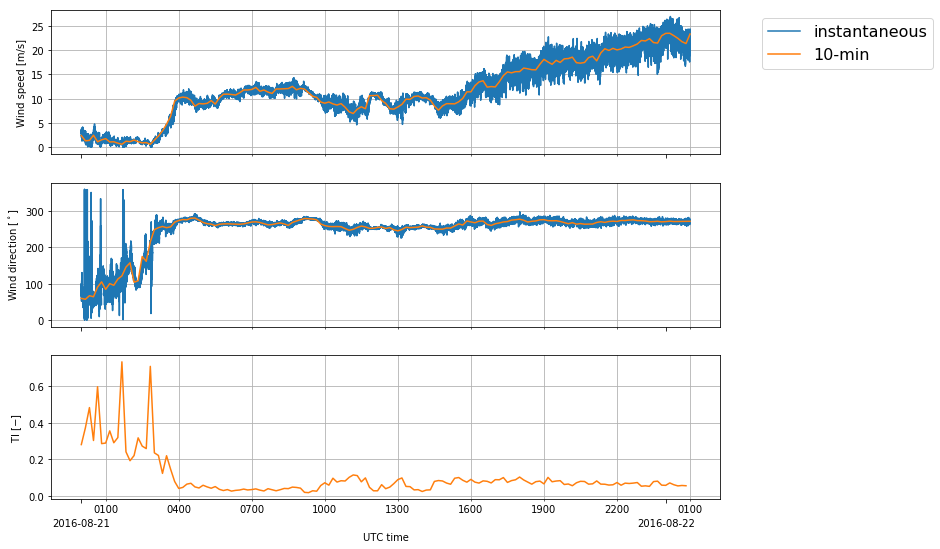

In [23]:
plot_timehistory_at_height({'instantaneous':df_s, '10-min':df_s_10min},
                           fields=['wspd','wdir','TI'],
                           heights=80)